# 1. Introduction

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from prml.feature.polynomial import PolynomialFeature
from prml.linear.linear_regression import LinearRegression
from prml.linear.ridge_regression import RidgeRegression
from prml.distribution.gaussian import Gaussian

## 1.1. Example: Polynomial Curve Fitting

For presentation purposes, consider a synthetically generated example dataset. The data were
generated from the function $\sin(2\pi x)$ by adding random Gaussian noise having standard
deviation $0.3$.

We generated $N{=}10$ observations spaced uniformly in range $[0,1]$. These observations
comprise the input data vector:

$
\large \mathsf{x} = (x_1,\dots,x_N)^T
$

For each generated observation $x$ we obtained its corresponding value of the function
$\sin(2\pi x)$ and then adding the random noise to capture the real-life situation of missing
information.

$
\large \mathsf{t} = (t_1,\dots,t_N)^T
$

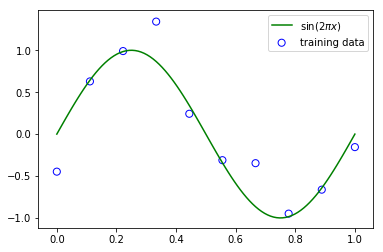

In [2]:
def create_toy_data(f, sample_size, std):
    x = np.linspace(0, 1, sample_size)
    t = f(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

def sin(x):
    return np.sin(2 * np.pi * x)

# Generate a train set
x_train, y_train = create_toy_data(sin, 10, 0.3)

# Generate a test set
x_test = np.linspace(0, 1, 100)
y_test = sin(x_test)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

The generated training dataset of $N{=}10$ points is shown as blue circles, each comprising an
observation of the input variable $x$ along with the corresponding target variable $t$. The
green curve shows the function $\sin(2\pi x)$ used to generate the data.

### Polynomial Linear Model

Our goal here is to predict the value of $\hat{t}$ for some new value of $\hat{x}$, without any
knowledge of the green curve. To that end, we consider a simple approach based on curve fitting.
In particular, we shall fit the data using a polynomial function of the form:

$
\large
y(x, \mathbf{w}) = w_0 + w_1x + w_2x^2 + \dots + w_Mx^M = \sum_{j=0}^M w_jx^j
$

where $M$ is the *order* of the polynomial.

**Note**: Functions, such as the function $y(x, \mathbf{w})$, that are linear functions of the
unknown parameters or coefficients $\mathbf{w}$, are called *linear models*.

### Error Function

Next, we need to determine the values of the coefficients $\mathbf{w}$ by fitting the polynomial
to the training data. This can be done by minimizing an *error function* that measures the
misfit between the function $y(x,\mathbf{w})$, for a given value of $\mathbf{w}$, and the
training data points.

One simple error function is the sum of squares of the errors between $y(x,\mathbf{w})$ and
the corresponding target values $t_n$:

$
\large
E(\mathbf{w}) = \frac{1}{2}\sum_{n=1}^N (y(x,\mathbf{w}) - t_n)^2 \geq 0
$

where the function becomes zero if, and only if, the function $y(x,\mathbf{w})$ were to pass
exactly through each training data point.

We can solve the curve fitting problem by choosing the value of $\mathbf{w}$ for which
$E(\mathbf{w})$ is as small as possible. Because the error function is quadratic, its
derivatives are linear, and so the minimization of the function has a unique closed from
solution, denoted by $\mathbf{w}^*$. To minimize the error function we should derive the
gradient vector, set it equal to zero and solve for $\mathbf{w}^*$:

$
\large
\nabla E(\mathbf{w}^*) = \mathbf{0}
$

First, we have to substitute the polynomial into the error function:

$
\large
E(\mathbf{w}) = \frac{1}{2}\sum_{n=1}^N (\sum_{j=0}^M w_jx_n^j - t_n)^2
$

Note that each of the $N$ data points from the generated training set has $1$ dimension, that is
$x \in \mathbb{R}$. However, the polynomial function populates $M$ features for each input $x$,
essentially transforming $x$ into a $M$-dimensional vector. Thus, the training set $\mathsf{x}$
can be written as a $N\times M$ matrix $\mathbf{X}$ where $\mathbf{X}_{nj}$ represents $x_n^j$,
that is, the $n$th input value raised in the power of $j$.

To find the gradient vector, we take the partial derivative of $E$ with respect to an arbitrary
$w_k$. Differentiating the sum, term by term, we get

$
\large
\begin{align*}
\nabla E(\mathbf{w}^*)_k &= \frac{\partial}{\partial w_k} (\mathbf{w}) \\
&= \frac{1}{2}\sum_{n=1}^N 2 (\sum_{j=0}^M w_jx_n^j - t_n)x_n^k
= \sum_{n=1}^N (\sum_{j=0}^M w_jx_n^j - t_n)x_n^k \\
&= \sum_{n=1}^N (\mathbf{X}\mathbf{w} - \mathsf{t})_n\mathbf{X}_{nk}
= \sum_{n=1}^N \mathbf{X}_{kn}^T(\mathbf{X}\mathbf{w} - \mathsf{t})_n \\
&= \big(\mathbf{X}^T(\mathbf{X}\mathbf{w} - \mathsf{t})\big)_k
\end{align*}
$

Using the partial derivative for one component, we compute the gradient vector by dropping the
$k$ subscript. Thus, the minimizer $\mathbf{w}^*$ must satisfy:

$
\large
\begin{equation*}
\nabla E(\mathbf{w}^*) = \mathbf{X}^T(\mathbf{X}\mathbf{w}^* - \mathsf{t}) = \mathbf{0}
\end{equation*}
$

Solving for $\mathbf{w}^*$ gives the unique solution of the curve fitting problem:

$
\large
\mathbf{X}^T(\mathbf{X}\mathbf{w}^* - \mathsf{t}) = \mathbf{0} \Leftrightarrow
\mathbf{X}^T\mathbf{X}\mathbf{w}^* = \mathbf{X}^T\mathsf{t} \Leftrightarrow
\mathbf{w}^* = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathsf{t}
$

The resulting polynomial is given by the function $y(x, \mathbf{w}^*)$.

### Model Selection

There remains the problem of choosing the order $M$ of the polynomial, which is
an example of the important concept called *model selection* or *model comparison*.

In order to study the effect of different $M$ values, we plot the result of fitting polynomials
having orders $M{=}0,1,3,9$ to the data set.

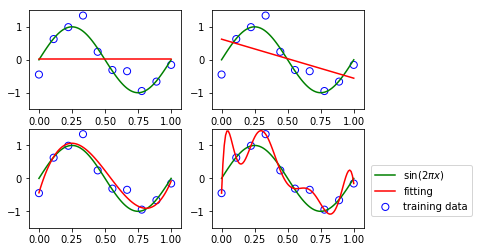

In [3]:
for i, degree in enumerate([0, 1, 3, 9]):
    plt.subplot(2, 2, i + 1)
    feature = PolynomialFeature(degree)
    X_train = feature.transform(x_train)
    X_test = feature.transform(x_test)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y = model.predict(X_test)

    plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
    plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
    plt.plot(x_test, y, c="r", label="fitting")
    plt.ylim(-1.5, 1.5)
    plt.annotate("M={}".format(degree), xy=(-0.15, 1))
plt.legend(bbox_to_anchor=(1.05, 0.64), loc=2, borderaxespad=0.)
plt.show()

Note that the constant ($M{=}0$) and first order ($M{=}1$) polynomials give rather poor fits to
the data. The third order ($M{=}3$) polynomial seems to give the best fit, while the higher
order one ($M{=}9$) achieves an excellent fit to the data ($E(\mathbf{w}^*){=}\mathbf{0}$).
However, the fitted curve gives a poor representation of the underlying function $\sin(2\pi x)$.
This phenomenon is known as *over-fitting*.

A more quantitative insight into the generalization performance on $M$ can be obtained by using the
root-mean-square (RMS) error defined as:

$
\large
E_{RMS} = \sqrt{2\frac{E(\mathbf{w}^*)}{N}}
$

The RMS error on both training and test data points for each value of $M$ is shown in the following figure:

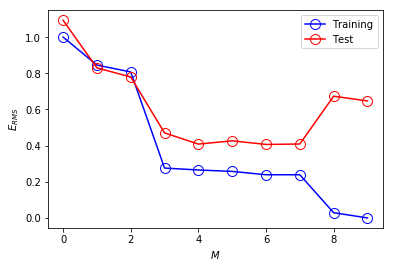

In [4]:
def rms_error(a, b):
    return np.sqrt(2 * np.mean(np.square(a - b)))

training_errors = []
test_errors = []

for i in range(10):
    feature = PolynomialFeature(i)
    X_train = feature.transform(x_train)
    X_test = feature.transform(x_test)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y = model.predict(X_test)
    training_errors.append(rms_error(model.predict(X_train), y_train))
    test_errors.append(rms_error(model.predict(X_test), y_test + np.random.normal(scale=0.25, size=len(y_test))))

plt.plot(training_errors, 'o-', mfc="none", mec="b", ms=10, c="b", label="Training")
plt.plot(test_errors, 'o-', mfc="none", mec="r", ms=10, c="r", label="Test")
plt.legend()
plt.xlabel("$M$")
plt.ylabel("$E_{RMS}$")
plt.show()

The test set error is measuring how well we are doing in predicting the values of $t$ for new data observations
of $x$. For $M{=}9$, the training set error goes to zero, because the polynomial contains $10$ degrees of freedom
and so it can be tuned exactly to the $10$ data points in the training set.

It is also interesting to examine the behavior of the model as the size of the data increases. The following figure
depicts the result of fitting the $M{=}9$ polynomial for $N{=}15$ and $N{=}100$ data points.

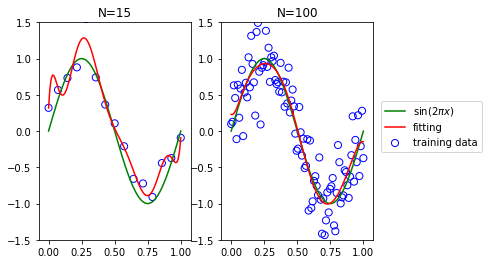

In [5]:
for i, size in enumerate([15, 100]):
    plt.subplot(1, 2, i + 1)

    # Generate a train set
    x_train_large, y_train_large = create_toy_data(sin, size, 0.3)

    # Generate a test set
    x_test_large = np.linspace(0, 1, 100)
    y_test_large = sin(x_test)

    feature = PolynomialFeature(9)
    X_train_large = feature.transform(x_train_large)
    X_test_large = feature.transform(x_test_large)

    model = LinearRegression()
    model.fit(X_train_large, y_train_large)
    y = model.predict(X_test_large)

    plt.scatter(x_train_large, y_train_large, facecolor="none", edgecolor="b", s=50, label="training data")
    plt.plot(x_test_large, y_test_large, c="g", label="$\sin(2\pi x)$")
    plt.plot(x_test_large, y, c="r", label="fitting")
    plt.ylim(-1.5, 1.5)
    plt.title("N={}".format(size))
plt.legend(bbox_to_anchor=(1.05, 0.64), loc=2, borderaxespad=0.)
plt.show()


Note that the over-fitting problem becomes less severe as the size of the data set increases.
In other words, the larger the data set, the more complex the model that we can afford to fit
to the data.

### Regularization

One technique that is often used to control the over-fitting phenomenon is that of *regularization*,
which adds a penalty term to the error function in order to discourage the coefficients from reaching
large values. The simplest such penalty term is the sum of squares of all of the coefficients,
leading to a modified error function of the following form:

$
\large
\tilde{E}(\mathbf{w}) = \frac{1}{2}\sum_{n=1}^N (y(x,\mathbf{w}) - t_n)^2 + \lambda||\mathbf{w}||^2
$

Such techniques are known as *shrinkage* methods because they reduce the value of the
coefficients. The particular case of the quadratic regularization is called *ridge regression*.
In neural networks, this approach is also known as *weight decay*.

Similar to the previous case, the ridge error function can be minimized exactly in closed form
as follows:

$
\large
\begin{align*}
\nabla E(\mathbf{w}^*)_k &= \frac{\partial}{\partial w_k} (\mathbf{w}) \\
&= \frac{1}{2}\sum_{n=1}^N 2 (\sum_{j=0}^M w_jx_n^j - t_n)x_n^k + \frac{1}{2}\lambda 2w_k \\
&= \sum_{n=1}^N (\sum_{j=0}^M w_jx_n^j - t_n)x_n^k + \lambda w_k \\
&= \sum_{n=1}^N (\mathbf{X}\mathbf{w} - \mathsf{t})_n\mathbf{X}_{nk} + \lambda w_k
= \sum_{n=1}^N \mathbf{X}_{kn}^T(\mathbf{X}\mathbf{w} - \mathsf{t})_n + \lambda w_k \\
&= \big(\mathbf{X}^T(\mathbf{X}\mathbf{w} - \mathsf{t})\big)_k + \lambda w_k
\end{align*}
$

Using the partial derivative for one component, we compute the gradient vector by dropping the
$k$ subscript. Thus, the minimizer $\mathbf{w}^*$ must satisfy:

$
\large
\begin{equation*}
\nabla E(\mathbf{w}^*) =
\mathbf{X}^T(\mathbf{X}\mathbf{w}^* - \mathsf{t}) + \lambda\mathbf{w}^*\mathbf{I}= \mathbf{0}
\end{equation*}
$

Solving for $\mathbf{w}^*$ gives the unique solution that minimizes the ridge error:

$
\large
\begin{align*}
& \mathbf{X}^T(\mathbf{X}\mathbf{w}^* - \mathsf{t}) + \lambda\mathbf{w}^*\mathbf{I} = \mathbf{0} \Leftrightarrow \\
& \mathbf{X}^T\mathbf{X}\mathbf{w}^* - \mathbf{X}^T\mathsf{t} + \lambda\mathbf{w}^*\mathbf{I} = \mathbf{0} \Leftrightarrow \\
& \mathbf{X}^T\mathbf{X}\mathbf{w}^* + \lambda\mathbf{w}^*\mathbf{I} = \mathbf{X}^T\mathsf{t} \Leftrightarrow \\
& \mathbf{w}^*(\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I}) = \mathbf{X}^T\mathsf{t} \Leftrightarrow \\
& \mathbf{w}^* = (\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I})^{-1}\mathbf{X}^T\mathsf{t}
\end{align*}
$

The following figures depict the results of fitting the polynomial of order $M{=}9$ to the
same data set as before but now using the regularized error function. We see that, for a value
of $\ln\lambda{=}−18$, the over-fitting has been suppressed and we now obtain a much closer
representation of the underlying function $\sin(2\pi x)$. If, however, we use too large a value
for $\lambda$ then we again obtain a poor fit.

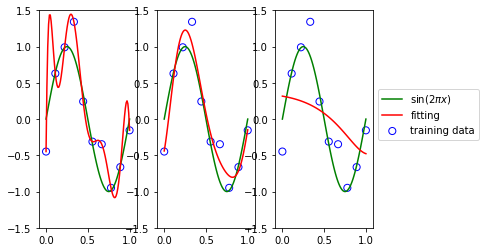

In [6]:
feature = PolynomialFeature(9)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

for i, l in enumerate([float('-inf'), -18, 0]):
    plt.subplot(1, 3, i + 1)

    model = RidgeRegression(alpha=math.exp(l))
    model.fit(X_train, y_train)
    y = model.predict(X_test)

    plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
    plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
    plt.plot(x_test, y, c="r", label="fitting")
    plt.ylim(-1.5, 1.5)
    plt.annotate("M=9", xy=(-0.15, 1))
plt.legend(bbox_to_anchor=(1.05, 0.64), loc=2, borderaxespad=0.)
plt.show()

A sample of coefficients from the fitted polynomials is presented in the table below, showing
that regularization has the desired effect of reducing the magnitude of the coefficients.

| $\ln\lambda{=}-\infty$ | $\ln\lambda{=}-18$ | $\ln\lambda{=}0$ |
|-----------------------:|-------------------:|-----------------:|
| $0.39$                 | $0.38$             | $0.36$           |
| $-135.04$              | $-2.14$            | $-0.46$          |
| $3206.76$              | $81,88$            | $-0.39$          |
| $-29215.92$            | $-390.51$          | $-0.22$          |
| $139594.34$            | $578.12$           | $-0.05$          |
| $-388863.80$           | $-31.48$           | $0.07$           |
| $652373.24$            | $-49.12$           | $0.17$           |
| $-648124.69$           | $-28.57$           | $0.25$           |
| $350721.94$            | $540.17$           | $0.31$           |
| $-79556.29$            | $-255.65$          | $0.35$           |

The impact of the regularization term on the generalization error can be seen by
plotting the value of the RMS error for both training and test sets against $\ln\lambda$,
as shown in the figure. We see that in effect $\lambda$ controls the effective complexity
of the model and hence determines the degree of over-fitting.

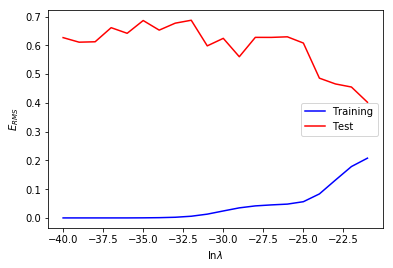

In [7]:
training_errors = []
test_errors = []
feature = PolynomialFeature(9)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

ln_of_lambda = range(-40, -20, 1)
for l in ln_of_lambda:

    model = RidgeRegression(alpha=math.exp(l))
    model.fit(X_train, y_train)
    training_errors.append(rms_error(model.predict(X_train), y_train))
    test_errors.append(rms_error(model.predict(X_test), y_test + np.random.normal(scale=0.25, size=len(y_test))))

plt.plot(ln_of_lambda, training_errors, mfc="none", mec="b", ms=10, c="b", label="Training")
plt.plot(ln_of_lambda, test_errors, mfc="none", mec="r", ms=10, c="r", label="Test")
plt.legend()
plt.xlabel("$\ln\lambda$")
plt.ylabel("$E_{RMS}$")
plt.show()

# 1.2 Probability Theory

The probability $p(E)$ of an event $E$ is always a non-negative number, i.e.,

$\large p(E) \geq 0$

The probability of an event E which is certain to occur is equal to one, i.e.,

$\large p(E) = 1$

If two events $E_1$ and $E_2$ are mutually exclusive, that is, they cannot occur
simultaneously, then the probability of occurrence of either $E_1$ or $E_2$
is denoted as $E_1 \cup E_2$ and is given by

$\large p(E_1 \cup E_2) = p(E_1) + p(E_2)$

Consider the slightly more general example involving two random variables $X$ and $Y$
instead of just two events. The probability that $X$ will take a value $x_i$ and $Y$
will take the value $y_j$ is written $p(X=x_i,Y=y_j)$ and is called the
joint probability of $X=x_i$ and $Y=y_j$, which is short notation
for $p(X=x_i \cap Y=y_j)$.

### Rules of Probability

#### Sum rule:

$
\large
\begin{equation*}
p(X) = \sum_Y p(X,Y) = \int p(X,Y) dy
\end{equation*}
$

Applying the sum rule as above is called "marginalizing out $y$".

#### Product rule:

$
\large
\begin{equation*}
p(X,Y) = p(Y|X)p(X)
\end{equation*}
$

Computing $p(X|Y)$ is called "conditioning on $y$". The product rule is generalized
as follows:

$
\large
\begin{equation*}
p(X_1,X_2,\dots,X_K) = p(X_K|X_{K-1},\dots,X_1)p(X_{K-1},\dots,X_1),\dots
\end{equation*}
$

Note that if the *joint distribution* of two random variables factorizes into the
product of their marginals, so that $p(X,Y) = p(X)p(Y)$, then $X$ and $Y$ are said to
be *statistically independent*. In such case, the product rule becomes $p(Y|X) = p(Y)$.

### Bayes Theorem

From the *product rule*, we can immediately obtain the
[*Bayes' theorem*](https://www.youtube.com/watch?v=HZGCoVF3YvM), using the
symmetry property $p(X, Y) = p(Y, X)$ as follows:

$
\large
\begin{align*}
& p(X,Y) = p(Y|X)p(X) \Leftrightarrow \\
& p(Y|X) = \frac{p(X, Y)}{p(X)} \Leftrightarrow \\
& p(Y|X) = \frac{p(Y, X)}{p(X)} \Leftrightarrow \\
& p(Y|X) = \frac{p(X|Y)p(Y)}{p(X)}
\end{align*}
$

Using the *sum* and *product rules*, the marginal probability $p(X)$ in the
denominator can be expressed in terms of the quantities in the numerator:

$
\large
\begin{equation*}
p(Y|X) = \frac{p(X|Y)p(Y)}{\sum_Y p(X,Y)} = \frac{p(X|Y)p(Y)}{\sum_Y p(X|Y)p(Y)}
\end{equation*}
$

An interpretation of the Bayes theorem is that if we had been asked
which is the most probable value of $Y$, *before* we observe any value for $X$,
then the most complete information we have available is provided by the
*prior probability* $p(Y)$. *After* we observe the value of $X$, we can use the
Bayes theorem to compute the the *posterior* probability $p(Y|X)$, which
represents our updated knowledge after incorporating the evidence provided
by the observed data.

Let $\mathbf{w}$ be parameters and $\mathcal{D}$ be data. Bayes theorem is given by

$
\large
\begin{equation*}
p(\mathbf{w}|\mathcal{D}) =
\frac{p(\mathcal{D}|\mathbf{w})p(\mathbf{w})}{p(\mathcal{D})}
\Leftrightarrow
\mathrm{posterior} =
\frac{\mathrm{likelihood}\, \times\, \mathrm{prior}}{\mathrm{evidence}}
\end{equation*}
$

The frequentist paradigm generally quantifies the properties of data driven
quantities in light of the fixed model parameters, while the Bayesian generally
quantify the properties of unknown model parameters in light of observed data.

* Frequentist: data $\mathcal{D}$ generated from a fixed $\mathbf{w}$.

* Bayesian: data $\mathcal{D}$ fixed, find best $\mathbf{w}$ given this data.

## 1.2.1 Probability densities

If the probability of a real-valued variable $x$ falling in the interval
$(x, x + \delta x)$ is given by $p(x)δx$, then $p(x)$ is called the probability
density function over x. The probability that $x$ will lie in an interval $(a, b)$
is then given by

$
\large
\begin{equation*}
p(a \leq x \leq b) = \int_a^b p(x)dx
\end{equation*}
$

and it must satisfy the following two conditions:

$
\large
\begin{align*}
p(x) \geq &0 \\
\int_{-\infty}^\infty p(x)dx = &1
\end{align*}
$

The probability that $x$ lies in the interval $(−\infty, z)$ is given by the
*cumulative distribution function* defined as:

$
\large
\begin{equation*}
P(z) = \int_{-\infty}^z p(x)dx
\end{equation*}
$

where

$\large p(x) = \frac{dP(x)}{dx}$

If $x$ is a discrete variable, then $p(x)$ is sometimes called a probability mass
function (PMF) because it can be regarded as a set of *probability masses* concentrated
at the allowed values of $x$.

## 1.2.2 Expectations and covariances

The average value of some function $f(x)$ under a probability distribution
$p(x)$ is called the *expectation* of $f(x)$ and is denoted by $\mathbb{E}[f]$.
The average is weighted by the relative probabilities of the different values
of $x$ as follows:

$
\large
\begin{equation*}
\mathbb{E}[f] = \sum_x p(x)f(x) = \int p(x)f(x)dx
\end{equation*}
$

For a finite number of $N$ points drawn from the probability distribution,
then the expectation can be approximated as a finite sum over these points:

$
\large
\begin{equation*}
\mathbb{E}[f] \approx \frac{1}{N} \sum_{n=1}^N f(x_n)
\end{equation*}
$

Note that the expectations of functions of several variables, may use a subscript
to indicate which variable is being averaged, i.e., $\mathbb{E}_x[f(x,y)]$.

The variance provides a measure of how much variability there is in $f(x)$
around its mean value $\mathbb{E}[f(x)]$ and is defined as follows:

$
\large
\begin{align*}
\mathrm{var}[f] &= \mathbb{E}[(f(x) − \mathbb{E}[f(x)])^2] \\
&= \mathbb{E}[f(x)^2 − 2f(x)\mathbb{E}[f(x)] + \mathbb{E}[f(x)]^2] \\
&= \mathbb{E}[f(x)^2] − \mathbb{E}[2f(x)\mathbb{E}[f(x)]] + \mathbb{E}[\mathbb{E}[f(x)]^2] \\
&= \mathbb{E}[f(x)^2] − 2\mathbb{E}[f(x)]\mathbb{E}[f(x)] + \mathbb{E}[f(x)]^2 \\
&= \mathbb{E}[f(x)^2] − \mathbb{E}[f(x)]^2
\end{align*}
$

The covariance expresses the extent to which $x$ and $y$ vary together and is given by

$
\large
\begin{equation*}
\mathrm{cov}[x, y] = \mathbb{E}_{x,y}[(x − \mathbb{E}[x])(y − \mathbb{E}[y])] =
\mathbb{E}_{x,y}[xy] − \mathbb{E}[x]\mathbb{E}[y]
\end{equation*}
$

A covariance matrix $\mathbf{\Sigma}$ has entries $\sigma_{ij}$ corresponding to
the covariance of variables $i$ and $j$. If two variables are independent, then
their covariance vanishes, e.g., $\mathbf{\Sigma} = \mathbf{I}$.

## 1.2.4 The Gaussian distribution

The *Normal* or *Gaussian* distribution is one of the most important probability
distributions for continuous variables. For the case of a single real-valued
variable $x$, the distribution is defined as follows:

$
\large
\begin{equation}
\mathcal{N}(x|\mu,\sigma^2) =
\frac{1}{(2\pi\sigma^2)^{1/2}}\exp\Big\{-\frac{1}{2\sigma^2}(x-\mu)^2\Big\}
\end{equation}
$

and is governed by the parameters $\mu$, called the *mean*, and $\sigma^2$, called
the *variance*. The square root of the variance $\sigma$ is called *standard deviation*,
while $\frac{1}{\sigma}^2$, is called the *precision*.

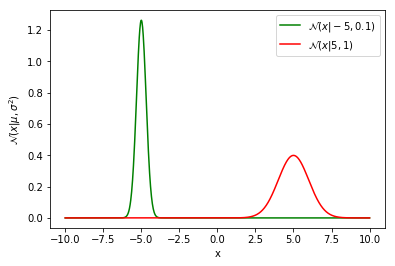

In [21]:
x = np.linspace(-10, 10, 1000)
N1 = Gaussian(-5, 0.1)
y1 = [N1.pdf(xi) for xi in x]
N2 = Gaussian(5, 1)
y2 = [N2.pdf(xi) for xi in x]

plt.plot(x, y1, c="g", label="$\mathcal{N}(x|-5,0.1)$")
plt.plot(x, y2, c="r", label="$\mathcal{N}(x|5,1)$")
plt.xlabel("x")
plt.ylabel("$\mathcal{N}(x|\mu,\sigma^2)$")
plt.legend()
plt.show()

Note that the probability density function is not an actual probability, therefore
it can take values $\mathcal{N}(x|\mu,\sigma^2) > 1$. We can see that the Gaussian
distribution satisfies,

$
\large
\mathcal{N}(x|\mu,\sigma^2) > 0
$

and we can also show that the Gaussian is normalized as follows:

$
\large
\begin{align*}
& \int \mathcal{N}(x|\mu,\sigma^2)dx = 1
\end{align*}
$

The Gaussian distribution can be also defined over a $D$-dimensional vector
$\mathbf{x}$ if continuous variables as follows:

$
\large
\begin{equation}
\mathcal{N}(\mathbf{x}|\mathbf{\mu},\mathbf{\Sigma}) =
\frac{1}{(2\pi)^{D/2}|\mathbf{\Sigma}|^{1/2}}
\exp\Big\{-\frac{1}{2}(\mathbf{x}-\mathbf{\mu})^T\mathbf{\Sigma}^{-1}(\mathbf{x}-\mathbf{\mu})\Big\}
\end{equation}
$

where the $D$-dimentional vector $\mathbf{\mu}$ holds the mean of each dimension,
while the $D\times D$ matrix $\mathbf{\Sigma}$ is the covariance.

### Maximum likelihood